# Transfer Learning ile Zatürre Sınıflandırma
- transfer learning nedir ?
  Transfer Learning daha önceden başka kişiler veya başka şirketler tarafından büyük veri setleri ile  eğitilmiş modelleri alıp kendi veri setlerimiz üzerinde fine-tuning yapma tekniğidir
  
- transfer learning model: densenet



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile

zip_path = "/content/drive/MyDrive/chest-xray.zip"
extract_path = "/content/chest_xray"   # Colab içine çıkarıyoruz

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset başarıyla çıkarıldı!")


Dataset başarıyla çıkarıldı!


# Kütüphane Eklenmesi


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D,Dense,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import os

# Data Augmentation and Preprocessing

In [10]:
train_datagen= ImageDataGenerator(
    rescale = 1/255.0 ,#normalizasyon
    horizontal_flip = True, # yatayda çevirme
    rotation_range = 10, # +-10 derece döndürme
    brightness_range = [0.8,1.2], # parlaklık ayarı
    validation_split =0.1 # validation için %10 ayırma

)# train data = train + validation

DATA_DIR = "/content/chest_xray/chest_xray"
IMG_SIZE =(224,224)
BATCH_SIZE = 64
CLASS_MODE="binary"
test_datagen = ImageDataGenerator(rescale =1/255.0)

train_gen = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR,"train"),
    target_size = IMG_SIZE, # Görüntüleri verdiğimiz değer yeniden boyutlandırma yapar
    batch_size = BATCH_SIZE, # batch boyutu
    class_mode = CLASS_MODE, # zatürre var yok
    subset = "training", # eğitim verisi
    shuffle =True, # karıştırma
)

val_gen = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR,"train"),
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = CLASS_MODE,
    subset = "validation",
    shuffle =False,
)

test_gen = test_datagen.flow_from_directory(
    os.path.join(DATA_DIR,"test"),
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = CLASS_MODE,
    shuffle =False,
)


Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Basic Visualization

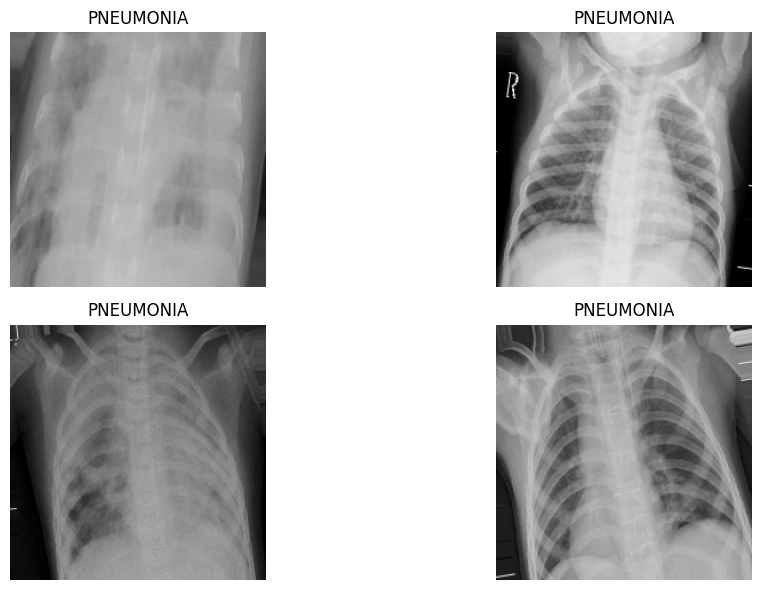

In [14]:
class_names = list(train_gen.class_indices.keys())  # sınıf isimleri
images, labels = next(train_gen)  # bir batch veri al

plt.figure(figsize=(12,6))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(images[i])
    plt.title(class_names[int(labels[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()


# Transfer Learning Model Tanımlama: densenet121

In [15]:
base_model = DenseNet121(
    weights ="imagenet", # imagenet veri setine göre eğitilmiş modelin ağırlıkları
    include_top = False, #son katmanları dahil etme (kendi katmanlarımızı ekleyeceğiz)
    input_shape = (*IMG_SIZE, 3)


)

base_model.trainable = False # base modeli dondur,base model train edilmeyecek,kendi katmanlarımızı train edeceğiz

# Kendi katmanlarımızı ekledik
x = base_model.output
x = GlobalAveragePooling2D()(x)
x =Dense(128,activation="relu")(x)
x = Dropout(0.5)(x)
pred = Dense(1,activation="sigmoid")(x) # ikili sınflandırma --> sigmoid


model = Model(inputs = base_model.input,outputs=pred) # Modeli tanımla

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Model Compile

In [17]:
model.compile(
    optimizer = Adam(learning_rate=0.0001),
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

callbacks = [
    EarlyStopping(monitor="val_loss",patience=3,restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss",factor=0.2,patience=2,min_lr = 1e-6),
    ModelCheckpoint("best_model.h5",monitor="val_loss",save_best_only=True)
]

print("Model Summary")
print(model.summary())


Model Summary


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,168,833 (27.35 MB)

 Trainable params: 131,329 (513.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

None


# Training


In [19]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=2,
    callbacks=callbacks
)


In [ ]:
pred_probs = model.predict(test_gen,verbose=1)
pred_labels =(pred_probs>0.5).astype(int).ravel()# olasılıklardan etiket üretme
true_labels = test_gen.classes
cm = confusion_matrix(true_labels,pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
plt.figure(figsize=(12,6))
disp.plot(cmap="blues",colorbar=False)
plt.title("Test Seti Confusion Matrix")
plt.show()